# Load Data and Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
%matplotlib inline

df_listings_bos = pd.read_csv('./boston/listings.csv')

df_listings_sea = pd.read_csv('./seattle/listings.csv')

In [3]:
df_listings_bos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [4]:
df_listings_sea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [5]:
def clean_data(df, is_bos=True):
    
    
    
    #Drop columns that are not quantitative nor categorical for price prediction
    drop_columns = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary','space',
                    'description', 'experiences_offered', 'neighborhood_overview', 'notes','transit',
                     'thumbnail_url', 'medium_url', 'picture_url', 'has_availability',
                    'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'host_response_time',
                    'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url',
                    'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
                    'street', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location',
                    'country_code', 'country', 'calendar_updated', 'calendar_last_scraped', 'jurisdiction_names',
                    'first_review', 'last_review', 'requires_license'
                   ]
    # The extra columns which only df_listings_bos has
    drop_columns_bos_extra = ['access', 'interaction', 'house_rules']
    
    df = df.drop(columns=drop_columns)
    
    # Drop the columns only in boston dataset
    if is_bos:
        df = df.drop(columns=drop_columns_bos_extra)
    
    # Drop columns that have less than 60% non-null value
    df.dropna(axis=1, thresh=len(df)*0.6, inplace=True)

    # Convert $ string into float
    for mon_col in ["cleaning_fee", "price", "extra_people"]:
        df[mon_col] = df[mon_col].str.replace("[$, ]", "").astype("float")
    
    # Convert t/f into binary True/False
    df["is_location_exact"]=df["is_location_exact"].apply(lambda x:True if x=="t" else False)
    df["host_is_superhost"]=df["host_is_superhost"].apply(lambda x:True if x=="t" else False)
    df["instant_bookable"]=df["instant_bookable"].apply(lambda x:True if x=="t" else False)
    df["require_guest_profile_picture"]=df["require_guest_profile_picture"].apply(lambda x:True if x=="t" else False)
    df["require_guest_phone_verification"]=df["require_guest_phone_verification"].apply(lambda x:True if x=="t" else False)
    # Convert string to datetime
    df["host_since"] = pd.to_datetime(df["host_since"])
    
    # The listing with NaN in cleaning fee should be 0
    df["cleaning_fee"].fillna(0, inplace=True)
    
    # Drop the rows without bathroom, bedroom, host_location ,bed and property_type since they only have very few missing value
    df.dropna(subset=["bathrooms", "bedrooms", "beds", "property_type", "host_location"], inplace=True)
    
    # Fill in the missing values in review with the mean
    for review in ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin",
                  "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month" ]:
        df[review].fillna(df[review].mean(), inplace=True)
    return df

df_listings_bos = clean_data(df_listings_bos)
df_listings_sea = clean_data(df_listings_sea, False)

In [6]:
df_listings_sea.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 0 to 3817
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3787 non-null   int64         
 1   host_since                        3787 non-null   datetime64[ns]
 2   host_location                     3787 non-null   object        
 3   host_is_superhost                 3787 non-null   bool          
 4   host_listings_count               3787 non-null   float64       
 5   host_total_listings_count         3787 non-null   float64       
 6   neighbourhood                     3372 non-null   object        
 7   neighbourhood_cleansed            3787 non-null   object        
 8   latitude                          3787 non-null   float64       
 9   longitude                         3787 non-null   float64       
 10  is_location_exact                 3787 non-null 

In [7]:
df_listings_sea.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 0 to 3817
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3787 non-null   int64         
 1   host_since                        3787 non-null   datetime64[ns]
 2   host_location                     3787 non-null   object        
 3   host_is_superhost                 3787 non-null   bool          
 4   host_listings_count               3787 non-null   float64       
 5   host_total_listings_count         3787 non-null   float64       
 6   neighbourhood                     3372 non-null   object        
 7   neighbourhood_cleansed            3787 non-null   object        
 8   latitude                          3787 non-null   float64       
 9   longitude                         3787 non-null   float64       
 10  is_location_exact                 3787 non-null 

count    3543.000000
mean      174.300875
std       148.900712
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

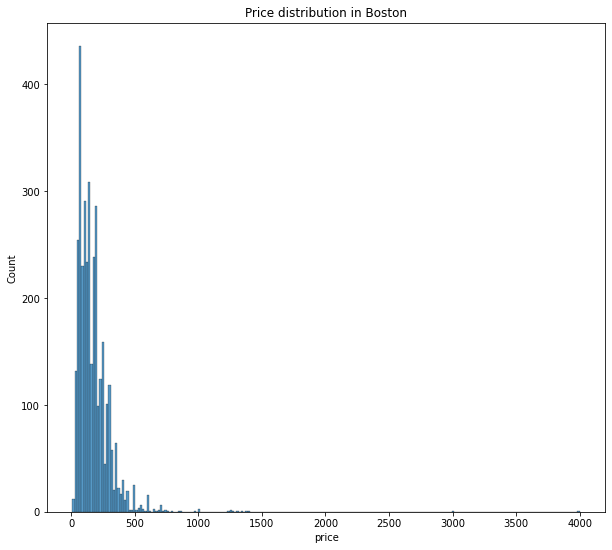

In [8]:
plt.figure(figsize=(10,9))
plt.title('Price distribution in Boston')
ax = sns.histplot(df_listings_bos['price'])
df_listings_bos['price'].describe()

In [9]:
# Removing outliers
df_listings_bos = df_listings_bos[df_listings_bos['price'] < 1200]

count    3787.000000
mean      128.063375
std        90.463742
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

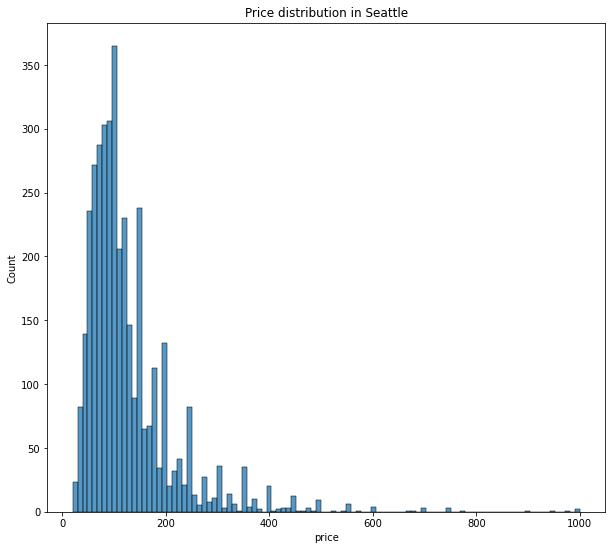

In [10]:
plt.figure(figsize=(10,9))
plt.title('Price distribution in Seattle')
ax = sns.histplot(df_listings_sea['price'])
df_listings_sea['price'].describe()

In [11]:
# Removing outliers
df_listings_sea = df_listings_sea[df_listings_sea['price'] < 800]

## Numerical variables

In [12]:
num_col_bos = df_listings_bos.select_dtypes(include=['float', 'int'])
num_col_sea = df_listings_sea.select_dtypes(include=['float', 'int'])
num_col_bos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3533 entries, 0 to 3584
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3533 non-null   int64  
 1   host_listings_count             3533 non-null   int64  
 2   host_total_listings_count       3533 non-null   int64  
 3   latitude                        3533 non-null   float64
 4   longitude                       3533 non-null   float64
 5   accommodates                    3533 non-null   int64  
 6   bathrooms                       3533 non-null   float64
 7   bedrooms                        3533 non-null   float64
 8   beds                            3533 non-null   float64
 9   price                           3533 non-null   float64
 10  cleaning_fee                    3533 non-null   float64
 11  guests_included                 3533 non-null   int64  
 12  extra_people                    35

In [13]:
num_col_bos.corr()['price'].sort_values(ascending=False).to_frame()


,price
price,1.000000
accommodates,0.561628
bedrooms,0.489606
beds,0.470107
cleaning_fee,0.408084
bathrooms,0.294119
guests_included,0.284118
latitude,0.243804
host_total_listings_count,0.235313
host_listings_count,0.235313


In [14]:
num_col_sea.corr()['price'].sort_values(ascending=False).to_frame()

,price
price,1.000000
accommodates,0.671811
bedrooms,0.648141
beds,0.610120
cleaning_fee,0.601023
bathrooms,0.527465
guests_included,0.399919
extra_people,0.124911
host_total_listings_count,0.102026
host_listings_count,0.102026


We can see that price, accommodates, bedrooms, beds, cleaning_fee, bathrooms, guests_included are highly correlated to price

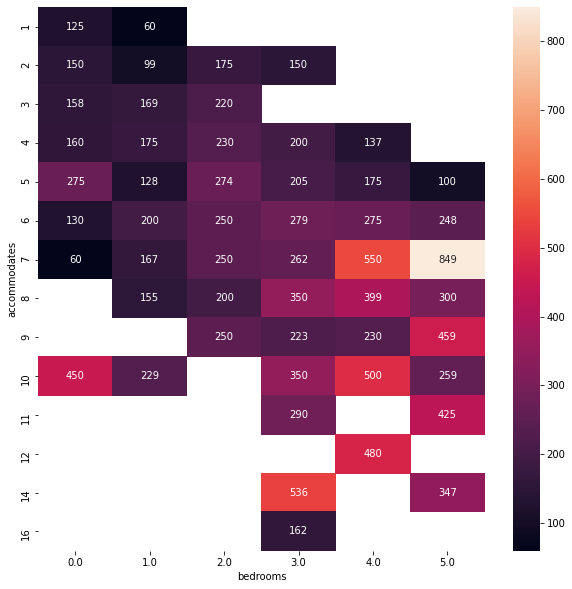

In [15]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(df_listings_bos.groupby(['accommodates', 'bedrooms']).median()['price'].unstack(), annot=True, fmt=".0f")

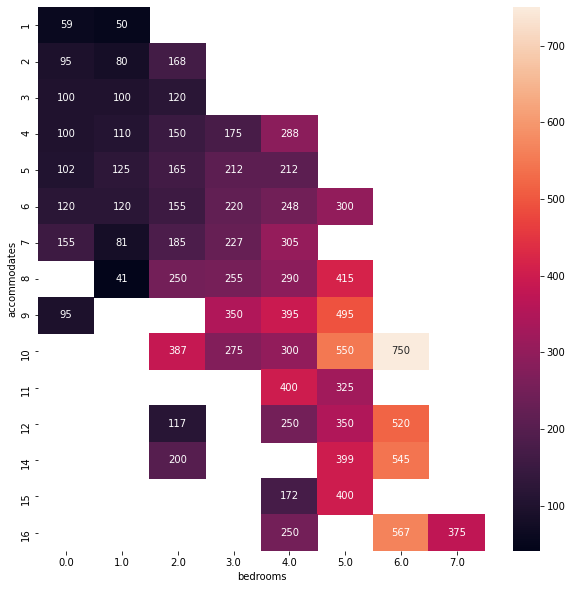

In [16]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(df_listings_sea.groupby(['accommodates', 'bedrooms']).median()['price'].unstack(), annot=True, fmt=".0f")

## Categorical Variables

In [17]:
cat_col = df_listings_bos.select_dtypes(include=['object'])
cat_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3533 entries, 0 to 3584
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   host_location           3533 non-null   object
 1   neighbourhood           3002 non-null   object
 2   neighbourhood_cleansed  3533 non-null   object
 3   property_type           3533 non-null   object
 4   room_type               3533 non-null   object
 5   bed_type                3533 non-null   object
 6   amenities               3533 non-null   object
 7   cancellation_policy     3533 non-null   object
dtypes: object(8)
memory usage: 248.4+ KB


In [18]:
df_listings_bos.host_location.value_counts()

Boston, Massachusetts, United States              2403
US                                                 502
New York, New York, United States                  112
Montreal, Quebec, Canada                            58
Middlesex County, Massachusetts, United States      50
                                                  ... 
Lynnfield, Massachusetts, United States              1
Randolph, Massachusetts, United States               1
California                                           1
Cleveland, Ohio, United States                       1
Keene, New Hampshire, United States                  1
Name: host_location, Length: 176, dtype: int64

### neighbourhood_cleansed

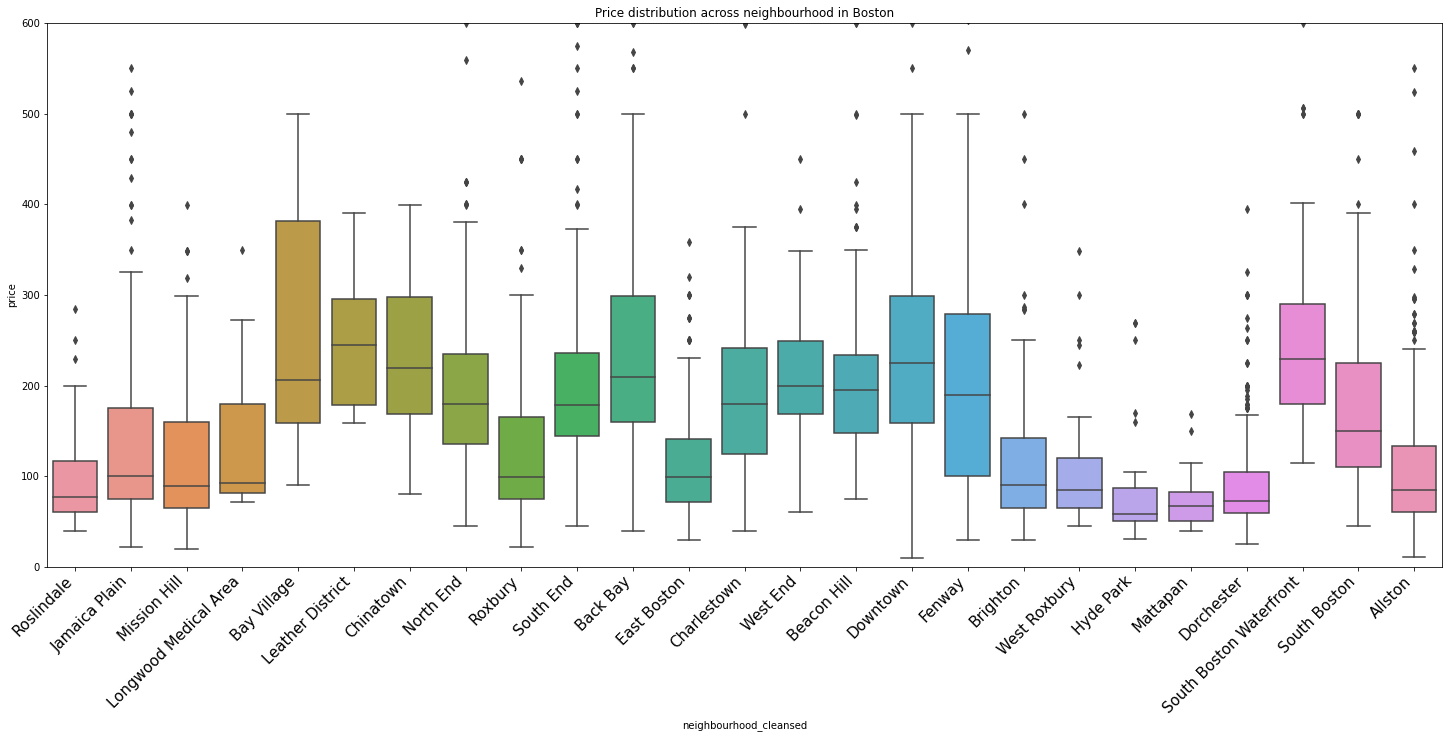

In [19]:
plt.figure(figsize=(25,10))
plt.title("Price distribution across neighbourhood in Boston")

sns.boxplot(data=df_listings_bos, x='neighbourhood_cleansed', y='price')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

plt.ylim([0,600])
plt.show()

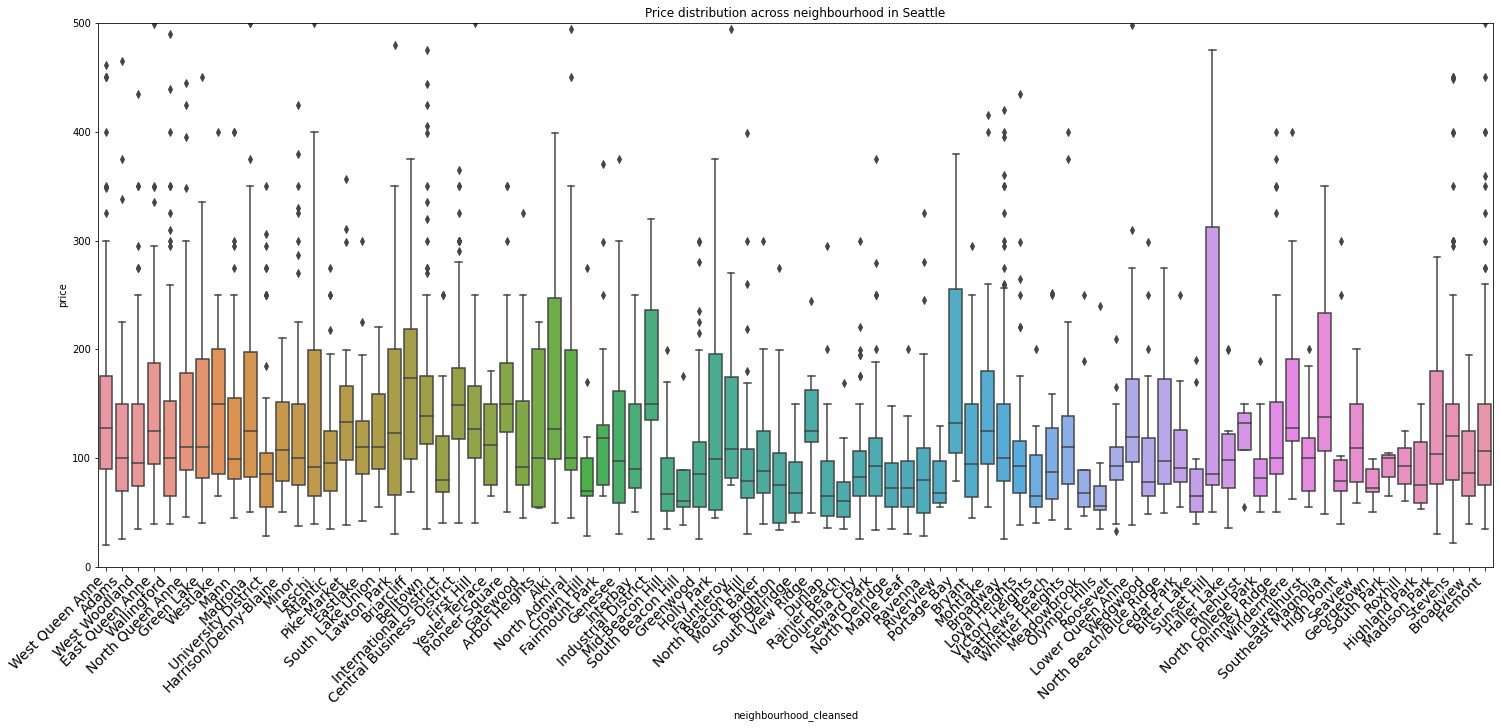

In [20]:
plt.figure(figsize=(25,10))
plt.title("Price distribution across neighbourhood in Seattle")

sns.boxplot(data=df_listings_sea, x='neighbourhood_cleansed', y='price')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14)

plt.ylim([0,500])
plt.show()

In [21]:
df_listings_bos['host_location'].value_counts()

Boston, Massachusetts, United States              2403
US                                                 502
New York, New York, United States                  112
Montreal, Quebec, Canada                            58
Middlesex County, Massachusetts, United States      50
                                                  ... 
Lynnfield, Massachusetts, United States              1
Randolph, Massachusetts, United States               1
California                                           1
Cleveland, Ohio, United States                       1
Keene, New Hampshire, United States                  1
Name: host_location, Length: 176, dtype: int64

<Figure size 720x648 with 0 Axes>

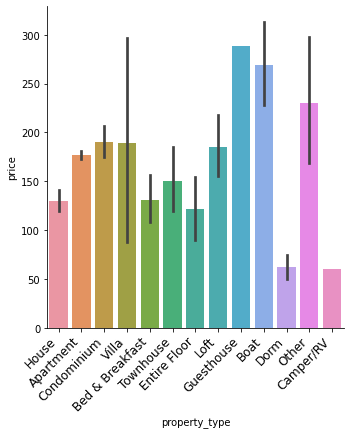

In [22]:
plt.figure(figsize=(10,9))
gx = sns.catplot(x='property_type', y='price', kind='bar', data=df_listings_bos)
gx.set_xticklabels(rotation=45, ha='right', fontsize=12)

<Figure size 720x648 with 0 Axes>

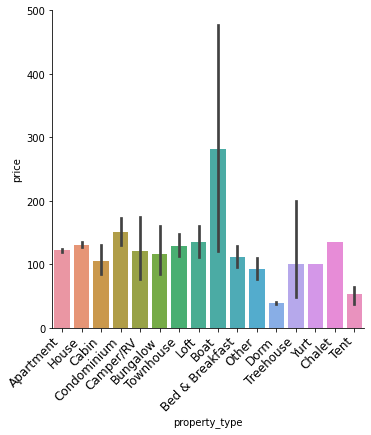

In [23]:
plt.figure(figsize=(10,9))
gx = sns.catplot(x='property_type', y='price', kind='bar', data=df_listings_sea)
gx.set_xticklabels(rotation=45, ha='right', fontsize=12)

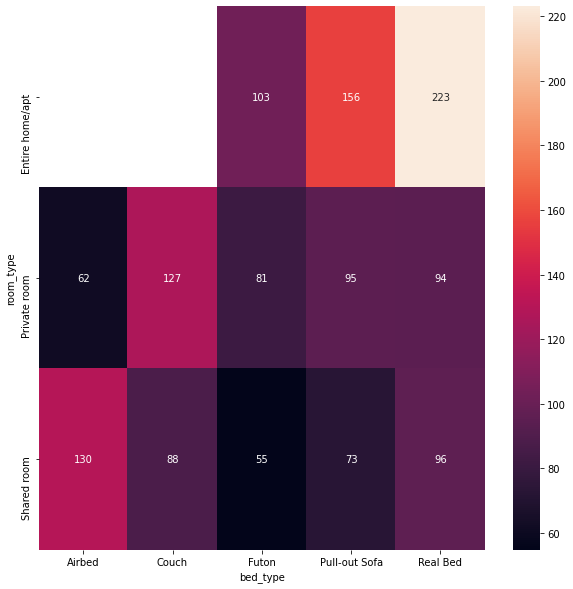

In [24]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(df_listings_bos.groupby(['room_type', 'bed_type']).mean()['price'].unstack(), annot=True, fmt=".0f")

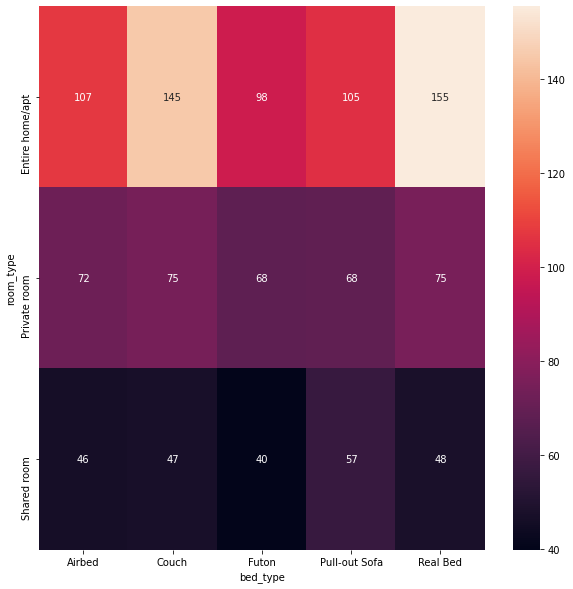

In [25]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(df_listings_sea.groupby(['room_type', 'bed_type']).mean()['price'].unstack(), annot=True, fmt=".0f")

In [26]:
df_listings_sea.groupby('cancellation_policy').mean().price

cancellation_policy
flexible    108.579456
moderate    114.253623
strict      153.160600
Name: price, dtype: float64

In [27]:
df_listings_bos.groupby('cancellation_policy').mean().price

cancellation_policy
flexible           142.112016
moderate           162.870330
strict             184.816327
super_strict_30    309.082192
Name: price, dtype: float64

In [28]:
cancellation_policy_price = pd.concat([df_listings_sea.groupby('cancellation_policy').mean().price.rename('Seattle price'), df_listings_bos.groupby('cancellation_policy').mean().price.rename('Boston price')], axis=1)

In [29]:
cancellation_policy_price

,Seattle price,Boston price
flexible,108.579456,142.112016
moderate,114.253623,162.870330
strict,153.160600,184.816327
super_strict_30,NaN,309.082192


In [30]:
df_listings_bos.select_dtypes(include=['bool']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3533 entries, 0 to 3584
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   host_is_superhost                 3533 non-null   bool 
 1   is_location_exact                 3533 non-null   bool 
 2   instant_bookable                  3533 non-null   bool 
 3   require_guest_profile_picture     3533 non-null   bool 
 4   require_guest_phone_verification  3533 non-null   bool 
dtypes: bool(5)
memory usage: 204.9 KB


### host_is_superhost

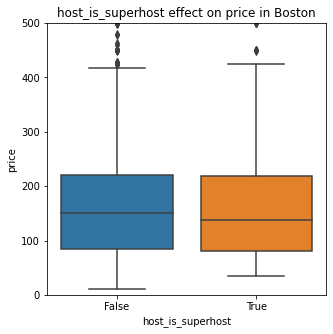

In [31]:
plt.figure(figsize=(5,5))
plt.title("host_is_superhost effect on price in Boston")

sns.boxplot(data=df_listings_bos, x='host_is_superhost', y='price')

plt.ylim([0,500])
plt.show()

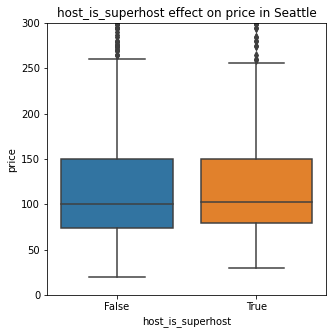

In [32]:
plt.figure(figsize=(5,5))
plt.title("host_is_superhost effect on price in Seattle")

sns.boxplot(data=df_listings_sea, x='host_is_superhost', y='price')

plt.ylim([0,300])
plt.show()

### is_location_exact

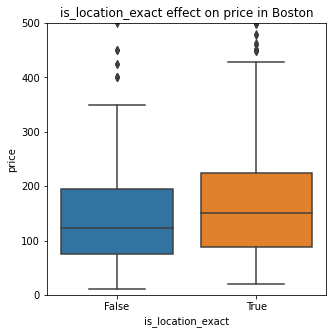

In [33]:
plt.figure(figsize=(5,5))
plt.title("is_location_exact effect on price in Boston")

sns.boxplot(data=df_listings_bos, x='is_location_exact', y='price')

plt.ylim([0,500])
plt.show()

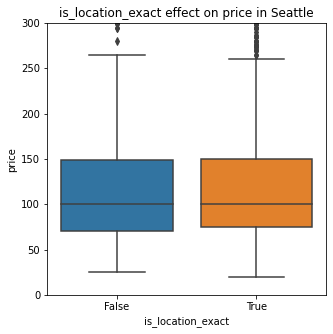

In [34]:
plt.figure(figsize=(5,5))
plt.title("is_location_exact effect on price in Seattle")

sns.boxplot(data=df_listings_sea, x='is_location_exact', y='price')

plt.ylim([0,300])
plt.show()

### instant_bookable

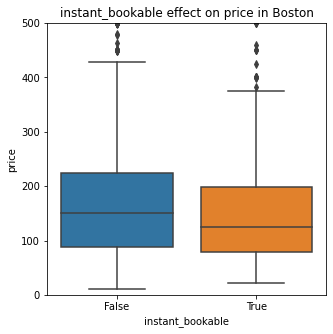

In [35]:
plt.figure(figsize=(5,5))
plt.title("instant_bookable effect on price in Boston")

sns.boxplot(data=df_listings_bos, x='instant_bookable', y='price')


plt.ylim([0,500])
plt.show()

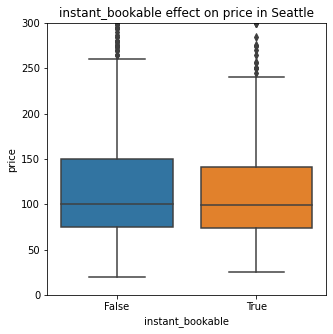

In [36]:
plt.figure(figsize=(5,5))
plt.title("instant_bookable effect on price in Seattle")

sns.boxplot(data=df_listings_sea, x='instant_bookable', y='price')


plt.ylim([0,300])
plt.show()

### require_guest_phone_verification

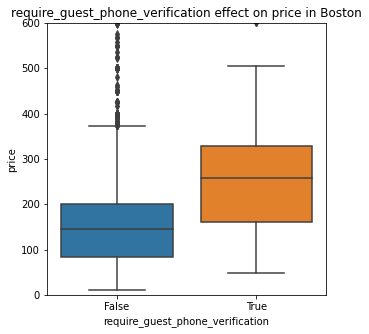

In [37]:
plt.figure(figsize=(5,5))
plt.title("require_guest_phone_verification effect on price in Boston")

sns.boxplot(data=df_listings_bos, x='require_guest_phone_verification', y='price')

plt.ylim([0,600])
plt.show()

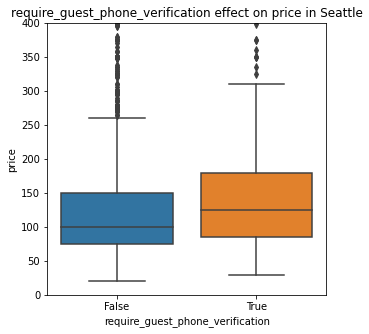

In [38]:
plt.figure(figsize=(5,5))
plt.title("require_guest_phone_verification effect on price in Seattle")

sns.boxplot(data=df_listings_sea, x='require_guest_phone_verification', y='price')

plt.ylim([0,400])
plt.show()

## Choose variables to train our model

In [39]:
def clean_data(df):

    # We select top 15 numerical variable correlated to price
    corr_num_vars = ['accommodates', 'bedrooms', 'beds', 'cleaning_fee', 'bathrooms', 'guests_included', 'reviews_per_month',
                    'longitude', 'host_listings_count', 'host_total_listings_count','number_of_reviews', 'calculated_host_listings_count',
                    'latitude', 'review_scores_location','availability_30' ]
    
    # We select Categorical variable correlated to price
    corr_cat_vars = ['neighbourhood_cleansed','property_type', 'room_type', 'bed_type', 'cancellation_policy']
    
    X = df[corr_num_vars + corr_cat_vars]
    y = df['price']
    
    X = create_dummy_df(X, corr_cat_vars, True)
    
    
    return X, y

In [40]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [41]:
def train_and_fit_model(X, y):

    # split test and train dataset from X and y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Create instance of Random Forest Regressor and evaluate model
    model = RandomForestRegressor(n_estimators=80, criterion='mse',  random_state=42)    
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    mse = mean_squared_error(y_test, prediction)
    r2 = r2_score(y_test, prediction)


    plt.figure(figsize=(24, 8))
    plt.title('Distribution of predicted vs actual values')
    ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values')
    ax2 = sns.kdeplot(data=prediction, color="r", label='Predicted values')
    

    plt.xlabel('Price')
    plt.show()
    print("Mean squared error of {0}: {1}".format(model, mse))
    print("R2 score : {0}".format(r2))


### Distribution of predicted vs actual values in Boston

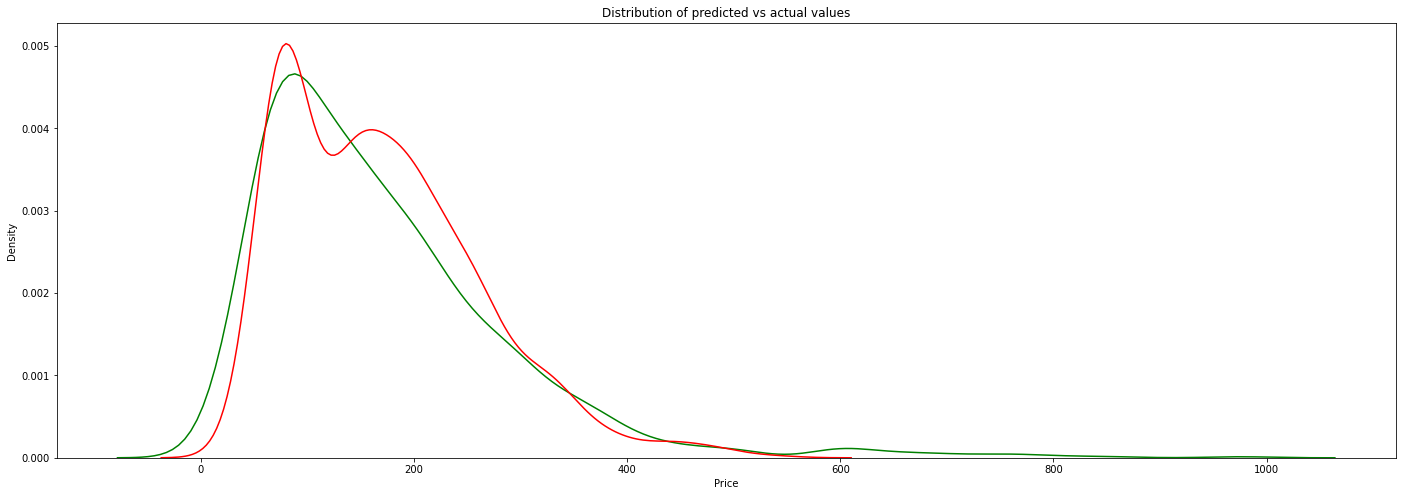

Mean squared error of RandomForestRegressor(n_estimators=80, random_state=42): 4951.758860701651
R2 score : 0.6526383708729646


In [42]:
X, y = clean_data(df_listings_bos)
train_and_fit_model(X, y)

### Distribution of predicted vs actual values in Seattle

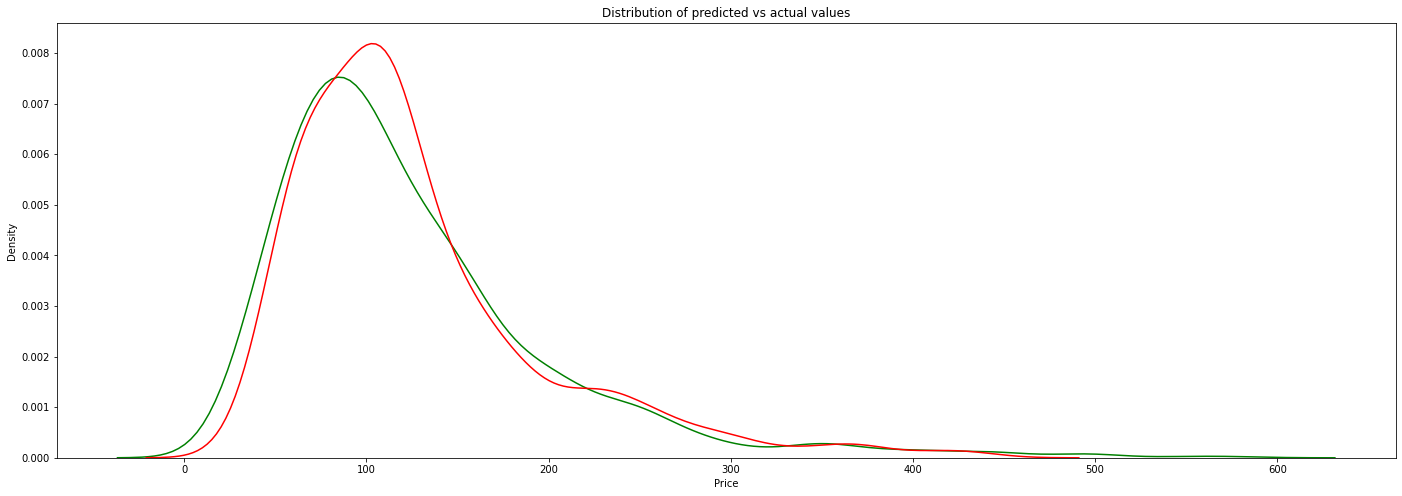

Mean squared error of RandomForestRegressor(n_estimators=80, random_state=42): 2102.715326404185
R2 score : 0.6458462230031067


In [43]:
X, y = clean_data(df_listings_sea)
train_and_fit_model(X, y)